In [1]:
# Import des bibliothèques nécessaires pour le projet
# - os et random pour la gestion des fichiers et l'aléatoire
# - numpy et PIL pour le traitement d'images et de tableaux
# - torch pour le deep learning
# - transformers pour le modèle pré-entraîné
# - peft pour LoRA
# - matplotlib pour les visualisations
import os
import random
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import (
    AutoImageProcessor, 
    AutoModelForDepthEstimation, 
    TrainingArguments, 
    Trainer
)
from peft import LoraConfig, get_peft_model
import matplotlib.pyplot as plt

c:\Users\natha\Documents\Git\LoRA-Depth-Anything\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Classe Dataset personnalisée pour charger les paires image-profondeur
class DepthDataset(Dataset):
    def __init__(self, pairs_list, images_path, depth_npy_path, image_processor):
        # Initialisation avec les chemins et le processeur d'images
        self.pairs_list = pairs_list
        self.images_path = images_path
        self.depth_npy_path = depth_npy_path
        self.image_processor = image_processor

    def __len__(self):
        # Retourne le nombre d'échantillons
        return len(self.pairs_list)

    def __getitem__(self, idx):
        # Charge une paire image-profondeur à l'index donné
        image_name, depth_npy_name = self.pairs_list[idx]
        
        image_file = os.path.join(self.images_path, image_name)
        depth_npy_file = os.path.join(self.depth_npy_path, depth_npy_name)
        
        image = Image.open(image_file).convert("RGB")
        depth_npy = np.load(depth_npy_file)
        
        # Gestion des canaux de profondeur (si 3D, prendre le canal Z)
        if depth_npy.ndim == 3:
            depth_npy = depth_npy[:, :, 2] 
            
        # Conversion en mètres si les valeurs sont en mm
        if np.nanmax(np.abs(depth_npy)) > 100:
            depth_npy = depth_npy / 1000.0
            
        # Nettoyage des valeurs négatives et NaN
        depth_npy[depth_npy < 0] = 0
        depth_npy = np.nan_to_num(depth_npy, nan=0.0, posinf=0.0, neginf=0.0)

        # Préparation des inputs pour le modèle
        inputs = self.image_processor(images=image, return_tensors="pt")
        
        # Préparation du tenseur de profondeur
        depth_tensor = torch.from_numpy(depth_npy).float()
        depth_tensor = depth_tensor.unsqueeze(0).unsqueeze(0)
        
        # Redimensionnement pour matcher la taille d'entrée du modèle
        target_size = inputs['pixel_values'].shape[-2:]
        depth_resized = F.interpolate(depth_tensor, size=target_size, mode='nearest')
        
        depth_resized = depth_resized.squeeze()

        # Retourne les données formatées pour l'entraînement
        return {
            'pixel_values': inputs['pixel_values'].squeeze(0),
            'labels': depth_resized,
            'image': image
        }

In [3]:
# Chargement du modèle pré-entraîné Depth-Anything et de son processeur d'images
model_id = "depth-anything/Depth-Anything-V2-Small-hf"
image_processor = AutoImageProcessor.from_pretrained(model_id)
model = AutoModelForDepthEstimation.from_pretrained(model_id)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
# Préparation des données : chargement des fichiers et division en train/eval/test
dataset_path = "DATASET_DEVOIR"
images_path = os.path.join(dataset_path, "images")
depth_npy_path = os.path.join(dataset_path, "depth")
image_files = sorted(os.listdir(images_path))
depth_files = sorted(os.listdir(depth_npy_path))
# Création des paires image-profondeur
all_pairs = list(zip(image_files, depth_files))
random.shuffle(all_pairs)

total = len(all_pairs)
# Division : 70% train, 15% eval, 15% test
train_split = int(0.7 * total)
eval_split = int(0.85 * total)

train_pairs = all_pairs[:train_split]
eval_pairs = all_pairs[train_split:eval_split]
test_pairs = all_pairs[eval_split:]

# Création des datasets
train_dataset = DepthDataset(train_pairs, images_path, depth_npy_path, image_processor)
eval_dataset = DepthDataset(eval_pairs, images_path, depth_npy_path, image_processor)
test_dataset = DepthDataset(test_pairs, images_path, depth_npy_path, image_processor)

In [5]:
# Affichage des noms des couches du modèle pour identifier celles à adapter avec LoRA
print("Noms de toutes les couches du modèle :")
for name, module in model.named_modules():
    if name:
        print(name)

Noms de toutes les couches du modèle :
backbone
backbone.embeddings
backbone.embeddings.patch_embeddings
backbone.embeddings.patch_embeddings.projection
backbone.embeddings.dropout
backbone.encoder
backbone.encoder.layer
backbone.encoder.layer.0
backbone.encoder.layer.0.norm1
backbone.encoder.layer.0.attention
backbone.encoder.layer.0.attention.attention
backbone.encoder.layer.0.attention.attention.query
backbone.encoder.layer.0.attention.attention.key
backbone.encoder.layer.0.attention.attention.value
backbone.encoder.layer.0.attention.output
backbone.encoder.layer.0.attention.output.dense
backbone.encoder.layer.0.attention.output.dropout
backbone.encoder.layer.0.layer_scale1
backbone.encoder.layer.0.drop_path
backbone.encoder.layer.0.norm2
backbone.encoder.layer.0.mlp
backbone.encoder.layer.0.mlp.fc1
backbone.encoder.layer.0.mlp.activation
backbone.encoder.layer.0.mlp.fc2
backbone.encoder.layer.0.layer_scale2
backbone.encoder.layer.1
backbone.encoder.layer.1.norm1
backbone.encoder.la

In [6]:
# Configuration de LoRA pour adapter le modèle avec peu de paramètres
# r : rang de la matrice LoRA, alpha : facteur d'échelle
# target_modules : couches à adapter (attention, query, etc.)
lora_config = LoraConfig(
    r=64,
    lora_alpha=128,
    target_modules=["query", "key", "value", "dense", "fc1", "fc2"], 
    lora_dropout=0.05,
    bias="none",
)

In [7]:
# Application de la configuration LoRA au modèle
lora_model = get_peft_model(model, lora_config)
# Affichage du nombre de paramètres entraînables
lora_model.print_trainable_parameters()

trainable params: 5,308,416 || all params: 30,093,505 || trainable%: 17.6397


In [8]:
# Classe Trainer personnalisée pour calculer la perte spécifique à la profondeur
class DepthTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Extraction des labels et prédiction
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth
        
        # Interpolation pour matcher les tailles si nécessaire
        if predicted_depth.shape[-2:] != labels.shape[-2:]:
            predicted_depth = F.interpolate(
                predicted_depth.unsqueeze(1), 
                size=labels.shape[-2:], 
                mode='bilinear', 
                align_corners=False
            ).squeeze(1)

        # Application de ReLU pour garantir des profondeurs positives
        predicted_depth = F.relu(predicted_depth) 

        # Masque pour ignorer les pixels invalides (zéros ou NaN)
        valid_mask = (labels > 0.001) & ~torch.isnan(labels)
        
        if valid_mask.sum() < 1:
            return torch.tensor(0.0, device=predicted_depth.device, requires_grad=True)

        pred_valid = predicted_depth[valid_mask]
        target_valid = labels[valid_mask]

        # Perte SiLog : robuste aux échelles pour la profondeur
        g = torch.log(pred_valid + 1e-6) - torch.log(target_valid + 1e-6)
        silog_loss = torch.mean(g ** 2) - 0.85 * (torch.mean(g) ** 2)
        
        # Ajout d'une perte L1 pour la précision
        l1_loss = F.l1_loss(pred_valid, target_valid)
        
        # Combinaison des pertes
        loss = 10.0 * silog_loss + 0.1 * l1_loss

        return (loss, outputs) if return_outputs else loss

In [9]:
# Configuration des arguments d'entraînement
args = TrainingArguments(
    output_dir="output_depth_lora",  # Dossier pour sauvegarder les checkpoints
    learning_rate=2e-4,  # Taux d'apprentissage
    lr_scheduler_type="cosine",  # Scheduler cosinus pour décroissance
    warmup_ratio=0.1,  # Ratio de warmup
    weight_decay=0.01,  # Régularisation L2
    
    per_device_train_batch_size=2,  # Taille de batch par GPU
    gradient_accumulation_steps=8,  # Accumulation pour simuler un batch plus grand
    
    num_train_epochs=30,  # Nombre d'époques
    fp16=True,  # Entraînement en précision mixte pour accélérer
    eval_strategy="epoch",  # Évaluation à chaque époque
    save_strategy="epoch",  # Sauvegarde à chaque époque
    load_best_model_at_end=True,  # Charger le meilleur modèle
    metric_for_best_model="eval_loss",  # Métrique pour le meilleur modèle
    remove_unused_columns=False,  # Garder les colonnes inutiles
    label_names=["labels"]  # Nom des labels
)

In [10]:
# Fonction de collation pour empiler les batches
def collate_fn(batch):
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])
    return {'pixel_values': pixel_values, 'labels': labels}

In [11]:
def compute_metrics(eval_pred):
    """
    Calcule les métriques standard de profondeur : Delta, AbsRel, RMSE.
    """
    predictions, labels = eval_pred
    
    # Suppression de la dimension canal si présente
    if predictions.ndim == 4:
        predictions = predictions.squeeze(1)
        
    # Application de max(0, x) comme dans le Trainer
    predictions = np.maximum(predictions, 0)
    
    # Masque de validité : pixels avec profondeur réelle
    valid_mask = (labels > 0.001) & (labels < 100.0) & (predictions > 0.001)
    
    pred_valid = predictions[valid_mask]
    target_valid = labels[valid_mask]
    
    if len(target_valid) == 0:
        return {"delta1": 0.0, "abs_rel": 0.0, "rmse": 0.0}

    # Calcul des métriques Delta (pourcentage de pixels précis)
    thresh = np.maximum((target_valid / pred_valid), (pred_valid / target_valid))
    delta1 = (thresh < 1.25).mean()
    delta2 = (thresh < 1.25 ** 2).mean()
    delta3 = (thresh < 1.25 ** 3).mean()

    # Erreur relative absolue moyenne
    abs_rel = np.mean(np.abs(pred_valid - target_valid) / target_valid)
    
    # Racine de l'erreur quadratique moyenne
    rmse = np.sqrt(np.mean((pred_valid - target_valid) ** 2))

    return {
        "delta1": delta1,
        "delta2": delta2, 
        "delta3": delta3,
        "abs_rel": abs_rel,
        "rmse": rmse
    }

In [12]:
# Initialisation du trainer avec le modèle LoRA, les arguments, datasets et fonctions
trainer = DepthTrainer(
    model=lora_model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

# Lancement de l'entraînement
trainer.train()

c:\Users\natha\Documents\Git\LoRA-Depth-Anything\env\Lib\site-packages\torch\nn\modules\module.py:1357: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:35.)
  return t.to(


Epoch,Training Loss,Validation Loss,Delta1,Delta2,Delta3,Abs Rel,Rmse
1,No log,4.670982,0.192891,0.378319,0.522627,1.356451,1.811111
2,No log,1.482100,0.394173,0.716876,0.847025,0.509846,0.677161
3,No log,1.279045,0.520211,0.786449,0.934140,0.269905,0.541146
4,No log,0.761940,0.605115,0.927124,0.983809,0.235374,0.380963
5,No log,0.622151,0.710563,0.909312,0.987378,0.219919,0.366716
6,No log,0.540769,0.427377,0.835259,0.990971,0.325640,0.459614
7,No log,0.386593,0.594970,0.920103,0.997127,0.175560,0.421024
8,No log,0.267538,0.767657,0.985712,0.999590,0.165586,0.301596
9,No log,0.239883,0.866721,0.988422,0.998602,0.129871,0.226199
10,No log,0.309888,0.816694,0.993570,0.999632,0.144291,0.267219


TrainOutput(global_step=90, training_loss=0.500354512532552, metrics={'train_runtime': 488.6007, 'train_samples_per_second': 2.456, 'train_steps_per_second': 0.184, 'total_flos': 2.8283657534496e+17, 'train_loss': 0.500354512532552, 'epoch': 30.0})

In [13]:
# Évaluation finale sur le jeu de test
test_metrics = trainer.evaluate(eval_dataset=test_dataset)

print("Résultats sur le Test Set :")
print(test_metrics)

Résultats sur le Test Set :
{'eval_loss': 0.06705348193645477, 'eval_delta1': 0.9794497986338225, 'eval_delta2': 0.9982989394727523, 'eval_delta3': 0.9995752175754886, 'eval_abs_rel': 0.04732564091682434, 'eval_rmse': 0.13929560780525208, 'eval_runtime': 2.0192, 'eval_samples_per_second': 4.457, 'eval_steps_per_second': 0.991, 'epoch': 30.0}


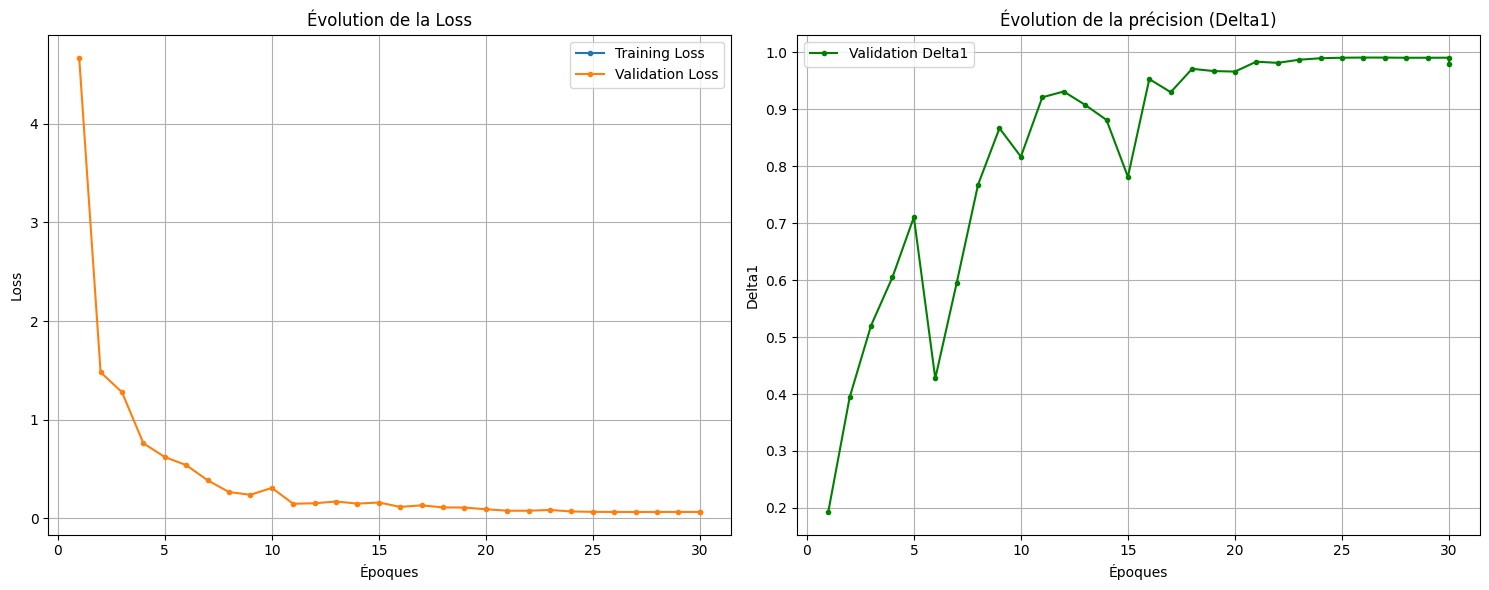

In [14]:
# Récupération de l'historique d'entraînement
history = trainer.state.log_history

# Listes pour stocker les valeurs
train_loss = []
train_epochs = []
val_loss = []
val_delta1 = []
val_epochs = []

# Extraction des données
for log in history:
    # Log de la perte d'entraînement
    if 'loss' in log:
        train_loss.append(log['loss'])
        train_epochs.append(log['epoch'])
    
    # Log des métriques d'évaluation (validation)
    if 'eval_loss' in log:
        val_loss.append(log['eval_loss'])
        val_delta1.append(log['eval_delta1']) # Le préfixe 'eval_' est ajouté automatiquement par le Trainer
        val_epochs.append(log['epoch'])

# Création des graphiques
plt.figure(figsize=(15, 6))

# 1. Graphique des Losses (Train & Val)
plt.subplot(1, 2, 1)
plt.plot(train_epochs, train_loss, label='Training Loss', marker='.')
plt.plot(val_epochs, val_loss, label='Validation Loss', marker='.')
plt.title('Évolution de la Loss')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 2. Graphique de la métrique Delta1
plt.subplot(1, 2, 2)
plt.plot(val_epochs, val_delta1, label='Validation Delta1', color='green', marker='.')
plt.title('Évolution de la précision (Delta1)')
plt.xlabel('Époques')
plt.ylabel('Delta1')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

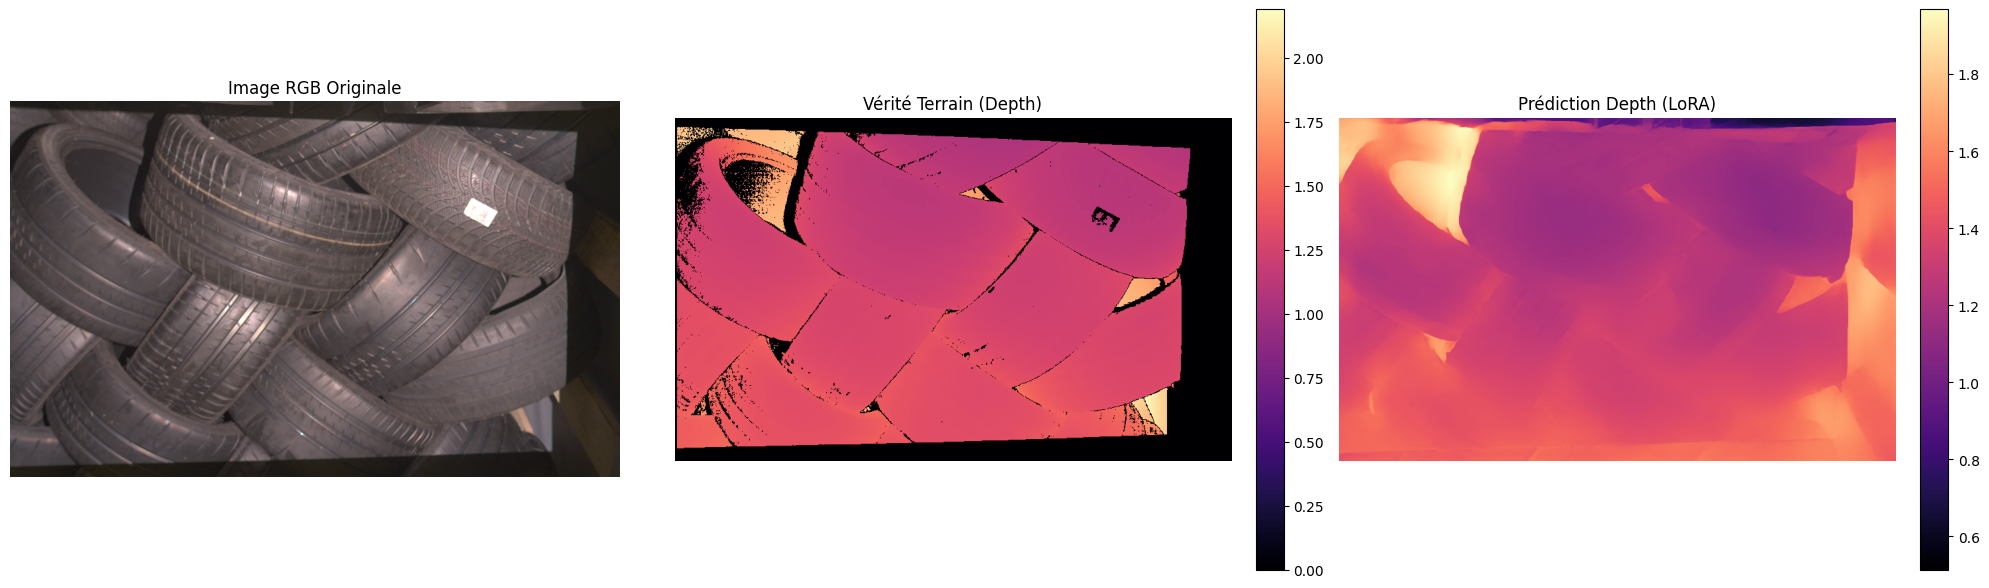

In [15]:
# Visualisation des résultats : comparaison image originale, ground truth et prédiction
import matplotlib.pyplot as plt
import torch
import numpy as np

# Passage en mode évaluation
lora_model.eval()

# Sélection d'un échantillon aléatoire du test set
idx = random.randint(0, len(test_dataset) - 1)
sample = test_dataset[idx]

original_image = sample['image']
ground_truth = sample['labels'].cpu().numpy()
pixel_values = sample['pixel_values'].unsqueeze(0)

# Déplacement sur GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pixel_values = pixel_values.to(device)
lora_model.to(device)

# Inférence sans gradient
with torch.no_grad():
    outputs = lora_model(pixel_values)
    predicted_depth = outputs.predicted_depth

    # Interpolation pour matcher la taille du ground truth
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=ground_truth.shape,
        mode="bicubic",
        align_corners=False,
    ).squeeze().cpu().numpy()

# Affichage des trois images côte à côte
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

axes[0].imshow(original_image)
axes[0].set_title("Image RGB Originale")
axes[0].axis("off")

im1 = axes[1].imshow(ground_truth, cmap='magma')
axes[1].set_title("Vérité Terrain (Depth)")
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(prediction, cmap='magma')
axes[2].set_title("Prédiction Depth (LoRA)")
axes[2].axis("off")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()